In [1]:
import os
from itertools import product
from collections import namedtuple
import time
from typing import Tuple
import random

from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.python.keras import engine
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats

In [2]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})
# matplotlib.rcParams.update({'font.weight': 'bold'})

In [33]:
pd.options.mode.chained_assignment = None
data = pd.read_csv('data/Tandem_network_with_m_ph_1_n_distribution.csv', index_col='Id')

COLUMNS = (
    'ArrAvg',
    'SrvAvg', 
    'SrvCv',
    'SrvSkewness', 
    'NetSize',
)

# COLUMNS = (
#     'ArrM1',
#     'SrvM1', 
#     'SrvM2',
#     'SrvM3', 
#     'NetSize',
# )

# COLUMNS = [
#     'ArrM1',
#     'ArrCv',
#     'ArrSkewness',
#     'SrvM1',
#     'SrvCv',
#     'SrvSkewness',
#     'NetSize', 
#     ]




In [34]:
data

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
0,37.680453,37.680453,0.620297,9.162685,1747.526983,0.620297,2.962755,4.776350,66.557691,0.050104,3.0,20.0,100000.0,4.206649,32.853086,0.997607
1,35.398955,35.398955,0.583228,7.884108,1367.617880,0.583228,2.746626,4.709351,65.356792,0.112330,7.0,20.0,100000.0,11.032834,66.745628,0.979369
2,37.478835,37.478835,0.565609,16.565423,4357.147398,0.565609,4.030572,7.126070,66.119231,0.132205,9.0,20.0,100000.0,34.000908,222.669607,0.904425
3,22.485905,22.485905,0.529263,13.942428,3398.398337,0.529263,3.696256,6.983777,66.863329,0.227582,11.0,20.0,100000.0,31.955233,160.049902,0.835318
4,36.295395,36.295395,0.662182,12.851327,5872.716118,0.662182,3.523186,5.320570,133.715951,0.236365,14.0,20.0,100000.0,28.220525,161.469039,0.905199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,35.482628,35.482628,0.608179,23.795561,12997.143633,0.608179,4.840008,7.958194,114.254042,0.118348,7.0,20.0,100000.0,25.509949,244.564696,0.947428
99996,36.242897,36.242897,0.731483,18.971254,10274.209594,0.731483,4.293738,5.869909,129.274138,0.040512,2.0,20.0,100000.0,2.486533,27.283843,0.999297
99997,45.736236,45.736236,0.985035,41.143479,21744.868897,0.985035,6.338232,6.434522,84.928938,0.303224,17.0,20.0,100000.0,64.490156,341.335750,0.787103


In [35]:
data.describe()

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.0,100000.0,100000.000000,100000.000000,100000.000000
mean,29.981103,29.981103,0.749828,23.776877,9580.549385,0.749828,4.667141,6.225119,77.850510,0.242634,10.50327,20.0,100000.0,76.527509,266.170945,0.793526
std,11.539266,11.539266,0.144420,11.878801,9636.478532,0.144420,1.188102,1.022509,41.497886,0.151091,5.75847,0.0,0.0,133.585723,250.929352,0.221820
min,10.000240,10.000240,0.500002,5.236594,60.481138,0.500002,2.232802,4.450013,4.463507,0.010072,1.00000,20.0,100000.0,0.532653,2.307368,0.015729
25%,19.973585,19.973585,0.624231,14.681587,2947.381771,0.624231,3.773297,5.340993,41.993858,0.128940,6.00000,20.0,100000.0,14.084938,87.126917,0.684375
50%,29.943022,29.943022,0.749836,21.220099,6379.775186,0.749836,4.540862,6.222448,77.621890,0.222810,11.00000,20.0,100000.0,38.224321,201.723973,0.871779
75%,39.941813,39.941813,0.874823,30.793644,12744.452853,0.874823,5.485068,7.110650,113.808447,0.328309,15.00000,20.0,100000.0,82.256296,368.491873,0.972514
max,49.999901,49.999901,0.999993,64.648646,72374.595687,0.999993,7.978061,7.999997,149.999086,0.954078,20.00000,20.0,100000.0,3620.942401,4961.267884,1.000000


In [36]:
len(data[data['DelayAvg']>500])

1890

In [37]:
simulation_data = data

In [38]:
# simulation_data = data[data['DelayAvg']<500]

In [39]:
# simulation_data = data[data['NetSize'] <=5]
# simulation_data

In [40]:
# simulation_data = data[(data['NetSize'] >=10) & (data['NetSize'] <=20)]

In [41]:
simulation_data['DelayAvg']

Id
0         4.206649
1        11.032834
2        34.000908
3        31.955233
4        28.220525
           ...    
99995    25.509949
99996     2.486533
99997    64.490156
99998     1.187886
99999    39.914198
Name: DelayAvg, Length: 100000, dtype: float64

In [42]:
# simulation_data = simulation_data[simulation_data['Rho']<.7] 

In [43]:
# simulation_data['DelayAvg'] = simulation_data['DelayAvg']*1000
# simulation_data['DelayAvg']
# simulation_data

In [44]:
simulation_data[simulation_data['DelayAvg']>.5]

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
0,37.680453,37.680453,0.620297,9.162685,1747.526983,0.620297,2.962755,4.776350,66.557691,0.050104,3.0,20.0,100000.0,4.206649,32.853086,0.997607
1,35.398955,35.398955,0.583228,7.884108,1367.617880,0.583228,2.746626,4.709351,65.356792,0.112330,7.0,20.0,100000.0,11.032834,66.745628,0.979369
2,37.478835,37.478835,0.565609,16.565423,4357.147398,0.565609,4.030572,7.126070,66.119231,0.132205,9.0,20.0,100000.0,34.000908,222.669607,0.904425
3,22.485905,22.485905,0.529263,13.942428,3398.398337,0.529263,3.696256,6.983777,66.863329,0.227582,11.0,20.0,100000.0,31.955233,160.049902,0.835318
4,36.295395,36.295395,0.662182,12.851327,5872.716118,0.662182,3.523186,5.320570,133.715951,0.236365,14.0,20.0,100000.0,28.220525,161.469039,0.905199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,35.482628,35.482628,0.608179,23.795561,12997.143633,0.608179,4.840008,7.958194,114.254042,0.118348,7.0,20.0,100000.0,25.509949,244.564696,0.947428
99996,36.242897,36.242897,0.731483,18.971254,10274.209594,0.731483,4.293738,5.869909,129.274138,0.040512,2.0,20.0,100000.0,2.486533,27.283843,0.999297
99997,45.736236,45.736236,0.985035,41.143479,21744.868897,0.985035,6.338232,6.434522,84.928938,0.303224,17.0,20.0,100000.0,64.490156,341.335750,0.787103


In [45]:
simulation_data[simulation_data['DelayAvg']>800]

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
247,17.278525,17.278525,0.959116,57.112803,6749.638115,0.959116,7.496192,7.815732,15.637599,0.407854,20.0,20.0,100000.0,1633.242698,707.596347,0.062664
265,19.515273,19.515273,0.784824,39.528949,5404.477867,0.784824,6.238029,7.948315,21.885005,0.308385,20.0,20.0,100000.0,1429.538970,1046.530265,0.087934
411,26.001417,26.001417,0.864549,29.017368,3159.531529,0.864549,5.316947,6.149965,20.528040,0.309731,20.0,20.0,100000.0,859.846876,783.033415,0.147293
662,13.135697,13.135697,0.961878,54.599459,4726.587030,0.961878,7.326271,7.616635,11.623702,0.466861,16.0,20.0,100000.0,1078.822634,627.089544,0.076737
810,15.984507,15.984507,0.715366,26.689789,1368.465179,0.715366,5.116448,7.152214,9.794925,0.420364,20.0,20.0,100000.0,809.425900,344.612705,0.131236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99490,11.735403,11.735403,0.971285,53.040049,9048.037501,0.971285,7.217801,7.431185,23.656298,0.448171,17.0,20.0,100000.0,1666.752883,1216.312777,0.035634
99526,10.300198,10.300198,0.874345,32.692788,4485.537037,0.874345,5.650514,6.462565,24.394914,0.420577,20.0,20.0,100000.0,1513.920410,1225.721341,0.027800
99804,14.646538,14.646538,0.943439,25.002091,1770.778211,0.943439,4.910398,5.204785,14.372463,0.440663,19.0,20.0,100000.0,999.136451,597.371594,0.082478


In [46]:
# simulation_data = simulation_data[simulation_data['DeliveryProb']>.8]
simulation_data

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
0,37.680453,37.680453,0.620297,9.162685,1747.526983,0.620297,2.962755,4.776350,66.557691,0.050104,3.0,20.0,100000.0,4.206649,32.853086,0.997607
1,35.398955,35.398955,0.583228,7.884108,1367.617880,0.583228,2.746626,4.709351,65.356792,0.112330,7.0,20.0,100000.0,11.032834,66.745628,0.979369
2,37.478835,37.478835,0.565609,16.565423,4357.147398,0.565609,4.030572,7.126070,66.119231,0.132205,9.0,20.0,100000.0,34.000908,222.669607,0.904425
3,22.485905,22.485905,0.529263,13.942428,3398.398337,0.529263,3.696256,6.983777,66.863329,0.227582,11.0,20.0,100000.0,31.955233,160.049902,0.835318
4,36.295395,36.295395,0.662182,12.851327,5872.716118,0.662182,3.523186,5.320570,133.715951,0.236365,14.0,20.0,100000.0,28.220525,161.469039,0.905199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,35.482628,35.482628,0.608179,23.795561,12997.143633,0.608179,4.840008,7.958194,114.254042,0.118348,7.0,20.0,100000.0,25.509949,244.564696,0.947428
99996,36.242897,36.242897,0.731483,18.971254,10274.209594,0.731483,4.293738,5.869909,129.274138,0.040512,2.0,20.0,100000.0,2.486533,27.283843,0.999297
99997,45.736236,45.736236,0.985035,41.143479,21744.868897,0.985035,6.338232,6.434522,84.928938,0.303224,17.0,20.0,100000.0,64.490156,341.335750,0.787103


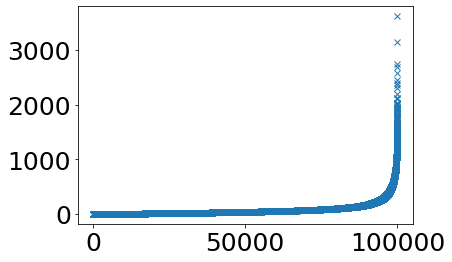

In [47]:
plt.plot(np.sort(simulation_data['DelayAvg']), 'x')

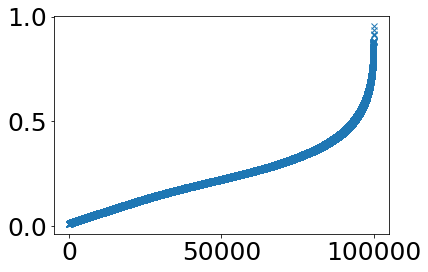

In [48]:
plt.plot(np.sort(simulation_data['Rho']), 'x')

<AxesSubplot:xlabel='DelayAvg', ylabel='Count'>

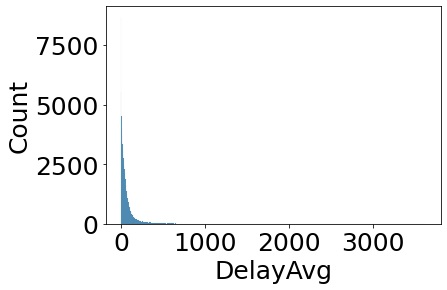

In [49]:
sns.histplot(simulation_data['DelayAvg'])

In [50]:
simulation_data[simulation_data['NetSize']==20]

,ArrM1,ArrAvg,SrvM1,SrvM2,SrvM3,SrvAvg,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
Id,,,,,,,,,,,,,,,,
33,43.443717,43.443717,0.950628,23.804130,4645.138933,0.950628,4.785440,5.033976,41.783251,0.294642,20.0,20.0,100000.0,236.606030,691.316043,0.495344
91,13.681942,13.681942,0.799403,31.772956,10502.669105,0.799403,5.579777,6.979926,60.024615,0.514877,20.0,20.0,100000.0,255.747688,986.177792,0.228001
92,23.320435,23.320435,0.531012,17.430767,4358.207406,0.531012,4.141110,7.798521,60.983404,0.297518,20.0,20.0,100000.0,112.661413,479.797133,0.453255
150,11.817425,11.817425,0.509902,11.428005,5272.280702,0.509902,3.341857,6.553921,140.803884,0.483234,20.0,20.0,100000.0,235.970925,1996.763003,0.299704
152,43.268300,43.268300,0.873938,31.364796,3351.703484,0.873938,5.531820,6.329764,19.321939,0.232942,20.0,20.0,100000.0,403.700048,566.703008,0.310568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99902,15.531101,15.531101,0.734789,16.931187,6585.940572,0.734789,4.048614,5.509901,98.692303,0.569857,20.0,20.0,100000.0,127.739226,601.497393,0.386855
99917,43.922701,43.922701,0.667034,14.604351,1845.874248,0.667034,3.762900,5.641240,34.107113,0.216543,20.0,20.0,100000.0,163.335877,466.253371,0.520739
99928,44.840840,44.840840,0.844386,18.429555,658.005745,0.844386,4.209105,4.984810,8.213993,0.278610,20.0,20.0,100000.0,389.431029,277.317481,0.457286


In [51]:
# simulation_data[simulation_data['Rho']>.9]

In [52]:
a = simulation_data[simulation_data['Rho']>.7]

In [53]:
a['DelayAvg']

Id
19        46.181645
168       41.018534
492      102.227787
914       77.178629
962      109.980428
            ...    
99385    139.242999
99506    129.652544
99556     65.433452
99870    104.369562
99949    111.618559
Name: DelayAvg, Length: 863, dtype: float64

In [54]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, ['DelayAvg', 'DeliveryProb']], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]

### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:

- Стандартное отклонение

In [55]:
def std(x: np.ndarray, y: np.ndarray) -> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [56]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- среднеквадратичная ошибка;

```sklearn.metrics.mean_squared_error ```;
- и коэффициент детерминации.

```sklearn.metrics.r2_score```.

### Приступим непосредственно к обучению

-  ## Задача регресии МНК

In [57]:
"""Prepare regression model using Least Squares algorithm"""
def get_ls_regression_model(x_train, x_test, 
                            y_train, y_test) -> (np.ndarray, LinearRegression):
    ls = LinearRegression()
    # ls = Ridge(alpha=.5)
    ls.fit(x_train, y_train)
    ls_y = ls.predict(x_test)

    return ls_y, ls

In [58]:
ls_delay_estimate, ls = get_ls_regression_model(x_train, x_test, 
                                                y_train['DelayAvg'], 
                                                y_test['DelayAvg'])

In [59]:
print(f'R = {corr(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ls_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ls_delay_estimate):.3f}')

R = 0.654
STD = 100.516
MSE = 10103.078
R2 = 0.428
MAPE = 5.159


In [60]:
# DataFrame для отриосвки графиков
draw_data = test_data
draw_data.loc[:,'DelayAvgTest'] = y_test.loc[:,'DelayAvg']
draw_data.loc[:, 'LsDelayEst'] = ls_delay_estimate

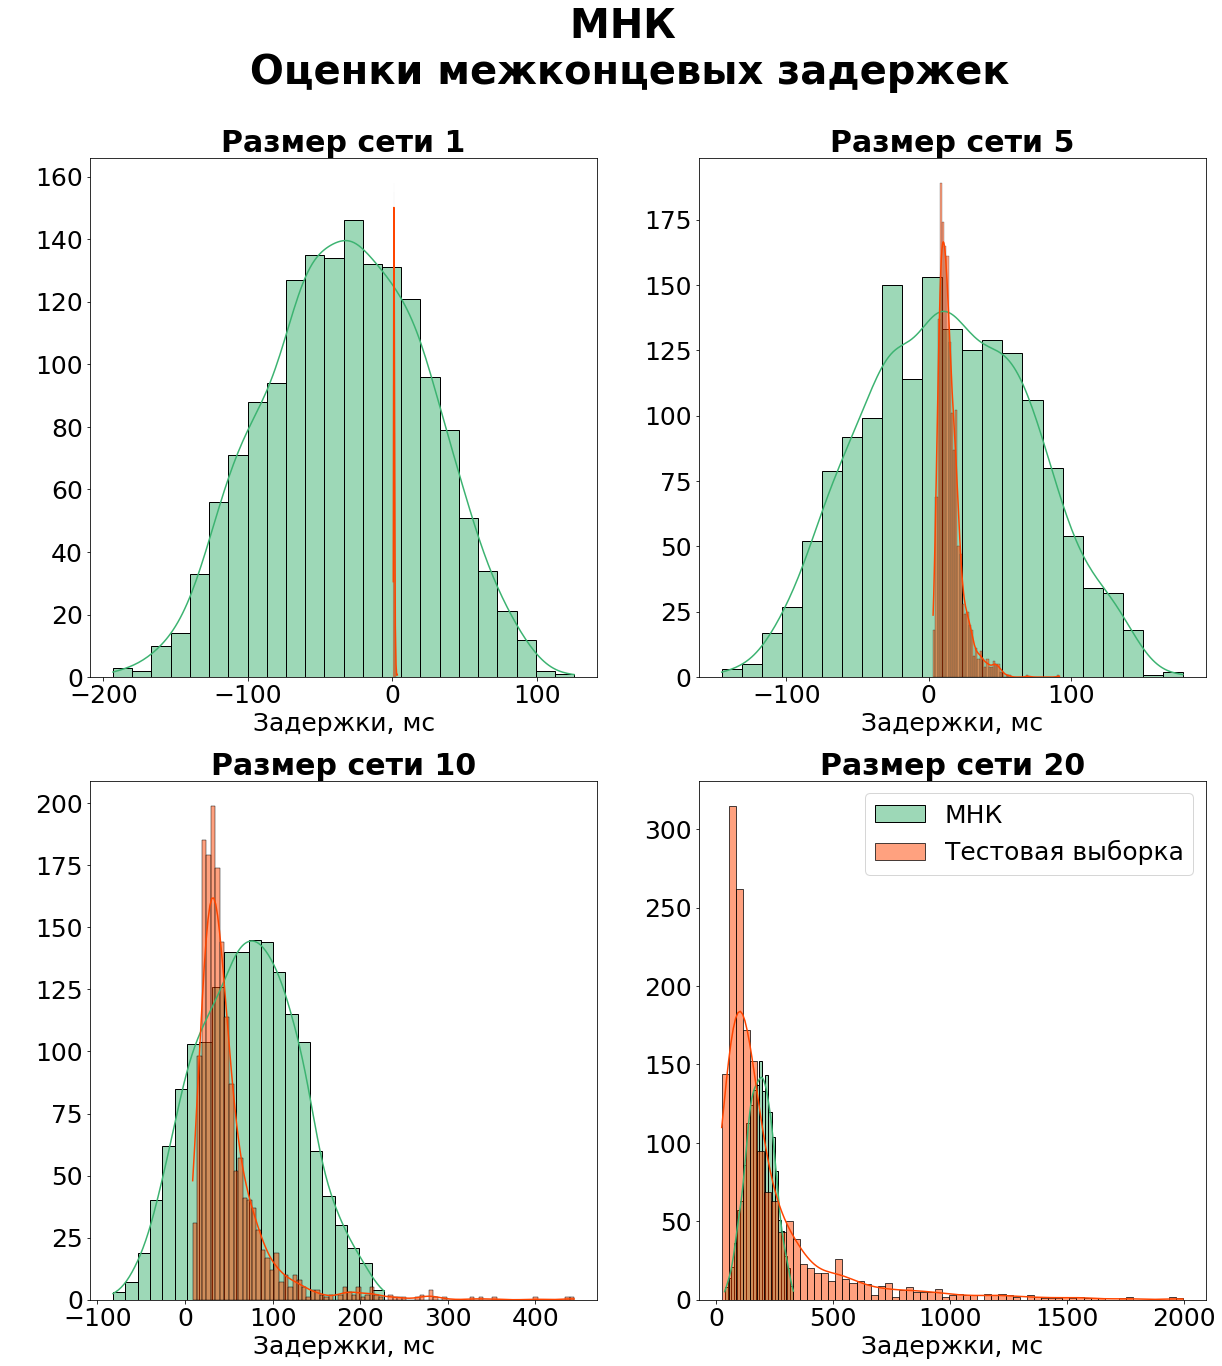

In [61]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('МНК \n Оценки межконцевых задержек \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Размер сети ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'LsDelayEst'], 
                          color="mediumseagreen", 
                          label="МНК", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Тестовая выборка", kde=True)
        
        k += 1
        plt.xlabel('Задержки, мс')
        plt.ylabel(' ')
plt.legend()
plt.savefig('data/m_ph_images/ls_histogram.png')

-  ## Задача регресии на дереве решений

In [62]:
"""Prepare regression model using Decision Tree algorithm"""
def get_tree_regression_model(x_train, x_test, 
                              y_train, y_test, 
                              max_depth=12, 
                              splitter='best') -> (np.ndarray, DecisionTreeRegressor):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, splitter=splitter, 
                                     criterion='mse')
    tree_reg.fit(x_train, y_train)
    tree_y = tree_reg.predict(x_test)
    
    # print(f'R = {corr(y_test, tree_y):.3f}')
    # print(f'STD = {std(y_test, tree_y):.3f}')
    # print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')

    return tree_y, tree_reg

In [63]:
tree_delay_estimate, tree_reg = get_tree_regression_model(x_train, x_test, 
                                                        y_train['DelayAvg'], 
                                                        y_test['DelayAvg'])

In [64]:
print(f'R = {corr(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], tree_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], tree_delay_estimate):.3f}')

R = 0.907
STD = 57.652
MSE = 3323.673
R2 = 0.812
MAPE = 0.249


In [65]:
draw_data.loc[:, 'TreeDelayEst'] = tree_delay_estimate 

In [66]:
draw_data.loc[:, 'TreeDelayEst'].describe()

count    33000.000000
mean        77.149215
std        134.078732
min          0.639694
25%         14.693213
50%         40.997212
75%         83.141863
max       3620.942401
Name: TreeDelayEst, dtype: float64

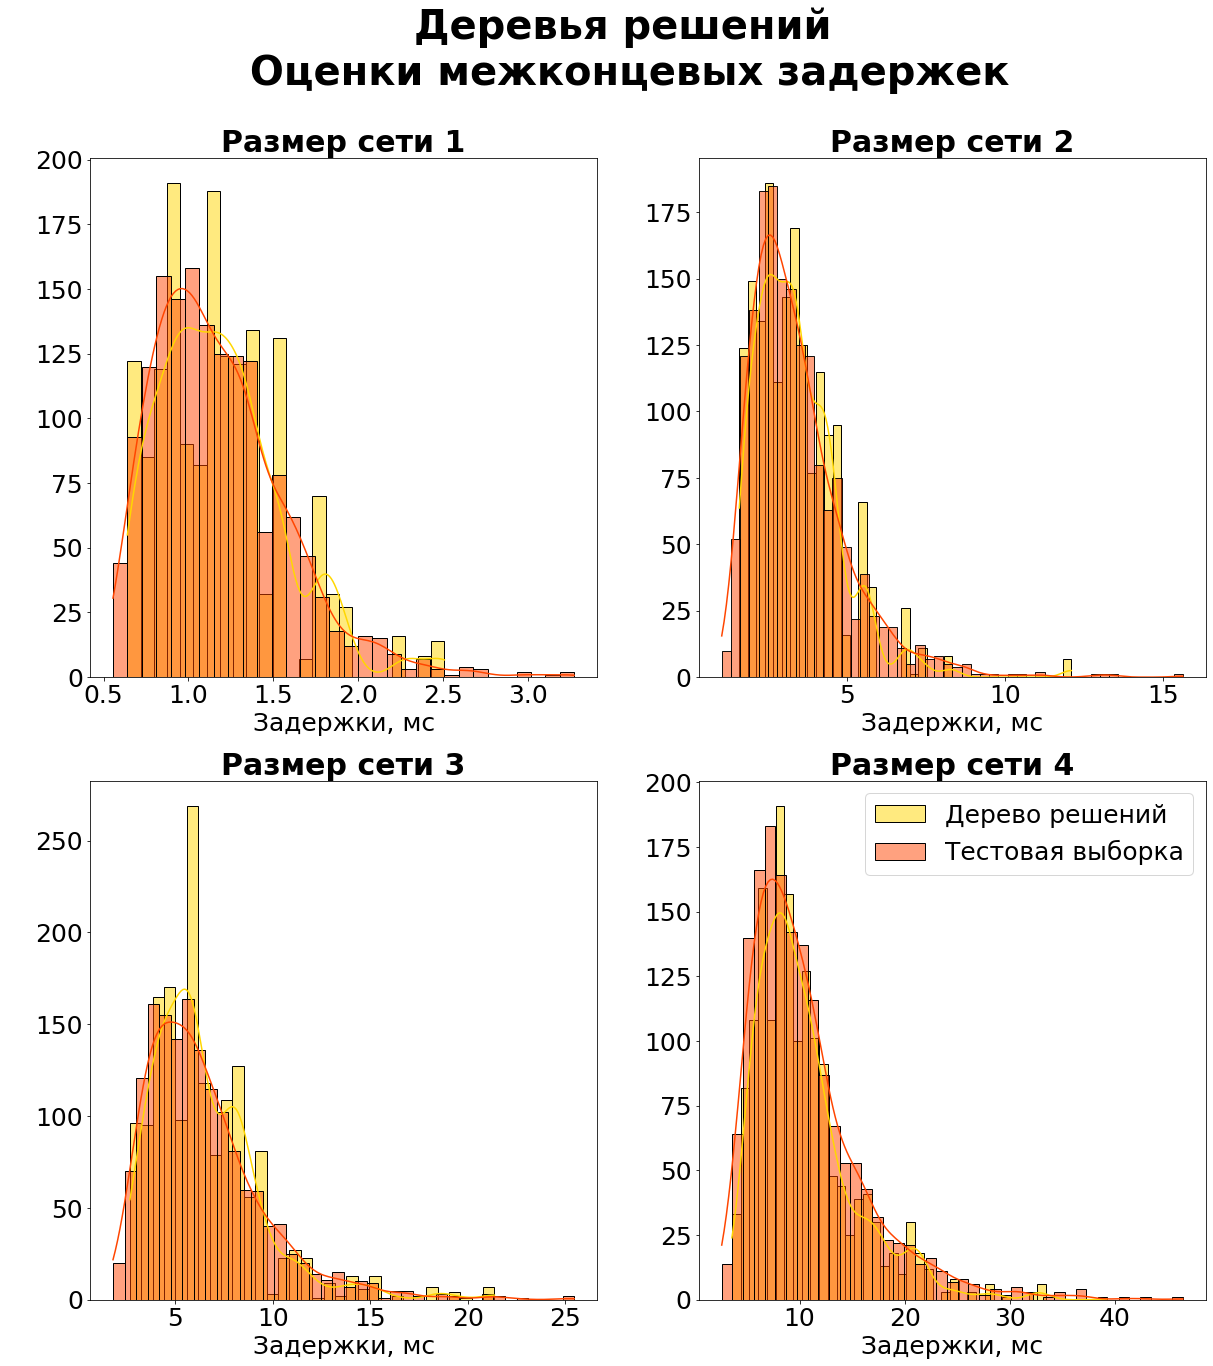

In [67]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Деревья решений \n Оценки межконцевых задержек \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    size = [1, 2, 3, 4]
#     size = [3, 8, 11, 15]
#     size = [i+1 for i in range(20)]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Размер сети ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", 
                          label="Дерево решений", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Тестовая выборка", kde=True)
        
        k += 1
        plt.xlabel('Задержки, мс')
        plt.ylabel(' ')
plt.legend()
plt.savefig('data/m_ph_images/tree_histogram.png')

-  ## Задача регрессии с помощью градиентного бустинга на деревьях решений

In [68]:
"""Prepare regression model using Gradient Boosting algorithm"""
def get_gtb_regression_model(x_train, x_test, 
                             y_train, y_test, 
                             n_estimators=100, 
                             learning_rate=.0001,
                             max_depth=12) -> (np.ndarray, GradientBoostingRegressor):
    gtb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth, criterion='mse')
    gtb.fit(x_train, y_train)
    gtb_y = gtb.predict(x_test)

    return gtb_y, gtb

In [69]:
gtb_delay_estimate, gtb = get_tree_regression_model(x_train, x_test, 
                                               y_train['DelayAvg'], 
                                               y_test['DelayAvg'])

In [70]:
print(f'R = {corr(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'STD = {std(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], gtb_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], gtb_delay_estimate):.3f}')

R = 0.912
STD = 55.785
MSE = 3111.902
R2 = 0.824
MAPE = 0.249


In [71]:
draw_data.loc[:, 'GTBDelayEst'] = gtb_delay_estimate 

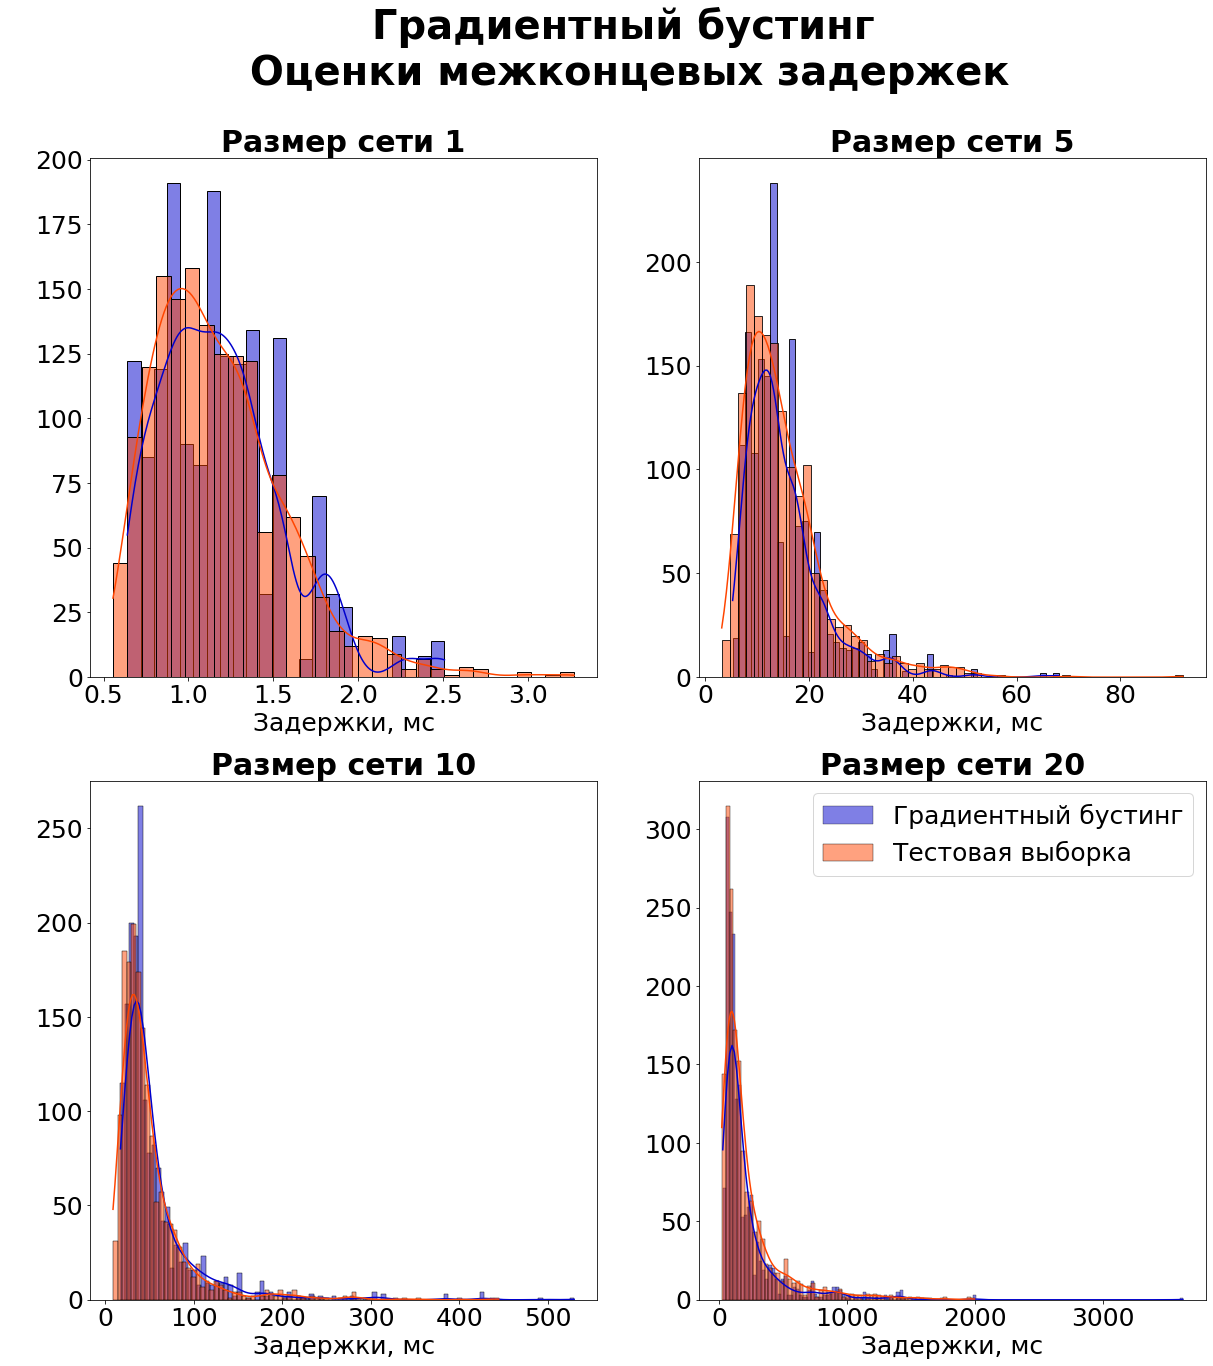

In [72]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Градиентный бустинг \n Оценки межконцевых задержек \n',  
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Размер сети ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="mediumblue", 
                          label="Градиентный бустинг", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Тестовая выборка", kde=True)
        
        
        k += 1
        plt.xlabel('Задержки, мс')
        plt.ylabel(' ')
plt.legend()
plt.savefig('data/m_ph_images/gtb_histogram.png')

-  ## Задача регрессии с помощью искуственной нейронной сети на алгоритме Adam

In [73]:
def normalize(table, stat) -> pd.core.frame.DataFrame:
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose()) / stat.loc['std',:].transpose()

In [74]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

In [75]:
train_normalize

,ArrAvg,SrvAvg,SrvCv,SrvSkewness,NetSize
Id,,,,,
59428,0.779990,0.495868,-0.070113,-0.001217,0.259918
34957,-0.804656,-1.558740,-1.443752,1.488144,-0.955683
4264,-0.307594,-0.677871,1.078691,-0.737542,0.607232
53791,0.128016,-0.858606,-0.666155,-1.250182,-0.434711
82114,-0.965349,-0.909528,1.466795,-0.465555,1.475519
...,...,...,...,...,...
6265,0.307162,1.142975,0.895961,-0.061899,0.780890
54886,0.365828,-1.325513,-0.160957,0.467291,0.607232
76820,-0.902261,0.852724,0.668460,-0.813795,-1.129340


In [109]:
def build_model(size, activation='sigmoid') -> np.ndarray:
    model = keras.Sequential([
        # Input Layer
#         layers.Dense(18, activation=activation, 
#                      use_bias=True, input_shape=[size]),
        layers.Flatten(input_shape=[size]),
        # Hidden Layer
#         layers.Dense(120, activation=activation),
#         layers.Dense(18, activation=activation, use_bias=True),
#         layers.Dense(360, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(120, activation=activation, use_bias=True),
#         layers.Dense(120, activation=activation, use_bias=True),
#         layers.Dense(120, activation=activation, use_bias=True),
#         layers.Dense(120, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
#         layers.Dense(36, activation=activation, use_bias=True),
        layers.Dense(72, activation=activation, use_bias=True),
#         layers.Dense(6, activation=activation, use_bias=True),
#         layers.Dense(6, activation=activation, use_bias=True),
        
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.1)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    print(model.summary())
    return model


def get_ann_regression_model(train_normalize, 
                             test_normalize, 
                             y_train_ann, y_test_ann, 
                             size,
                             epochs=10000,
                             activation='sigmoid') -> Tuple[np.ndarray, 
                                                            engine.sequential.Sequential]:
    
    ann = build_model(size=size)
   
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    EPOCHS = epochs
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    ann.fit(train_normalize, y_train_ann, epochs=EPOCHS, validation_split=0.3, verbose=0, 
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    ann_y = ann.predict(test_normalize).flatten();
    
    return ann_y, ann
# 

In [ ]:
%%time
ann_delay_estimate, ann = get_ann_regression_model(train_normalize, test_normalize,
                                                   y_train['DelayAvg'], y_test['DelayAvg'],
                                                   size=len(simulation_data.loc[:,COLUMNS].keys()),
                                                   activation='sigmoid')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 72)                432       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(f'R = {corr(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'STD = {std(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test["DelayAvg"], ann_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test["DelayAvg"], ann_delay_estimate):.3f}')

In [ ]:
# Добавим в draw_data оценку ann_y 
draw_data['AnnDelayEst'] = ann_delay_estimate

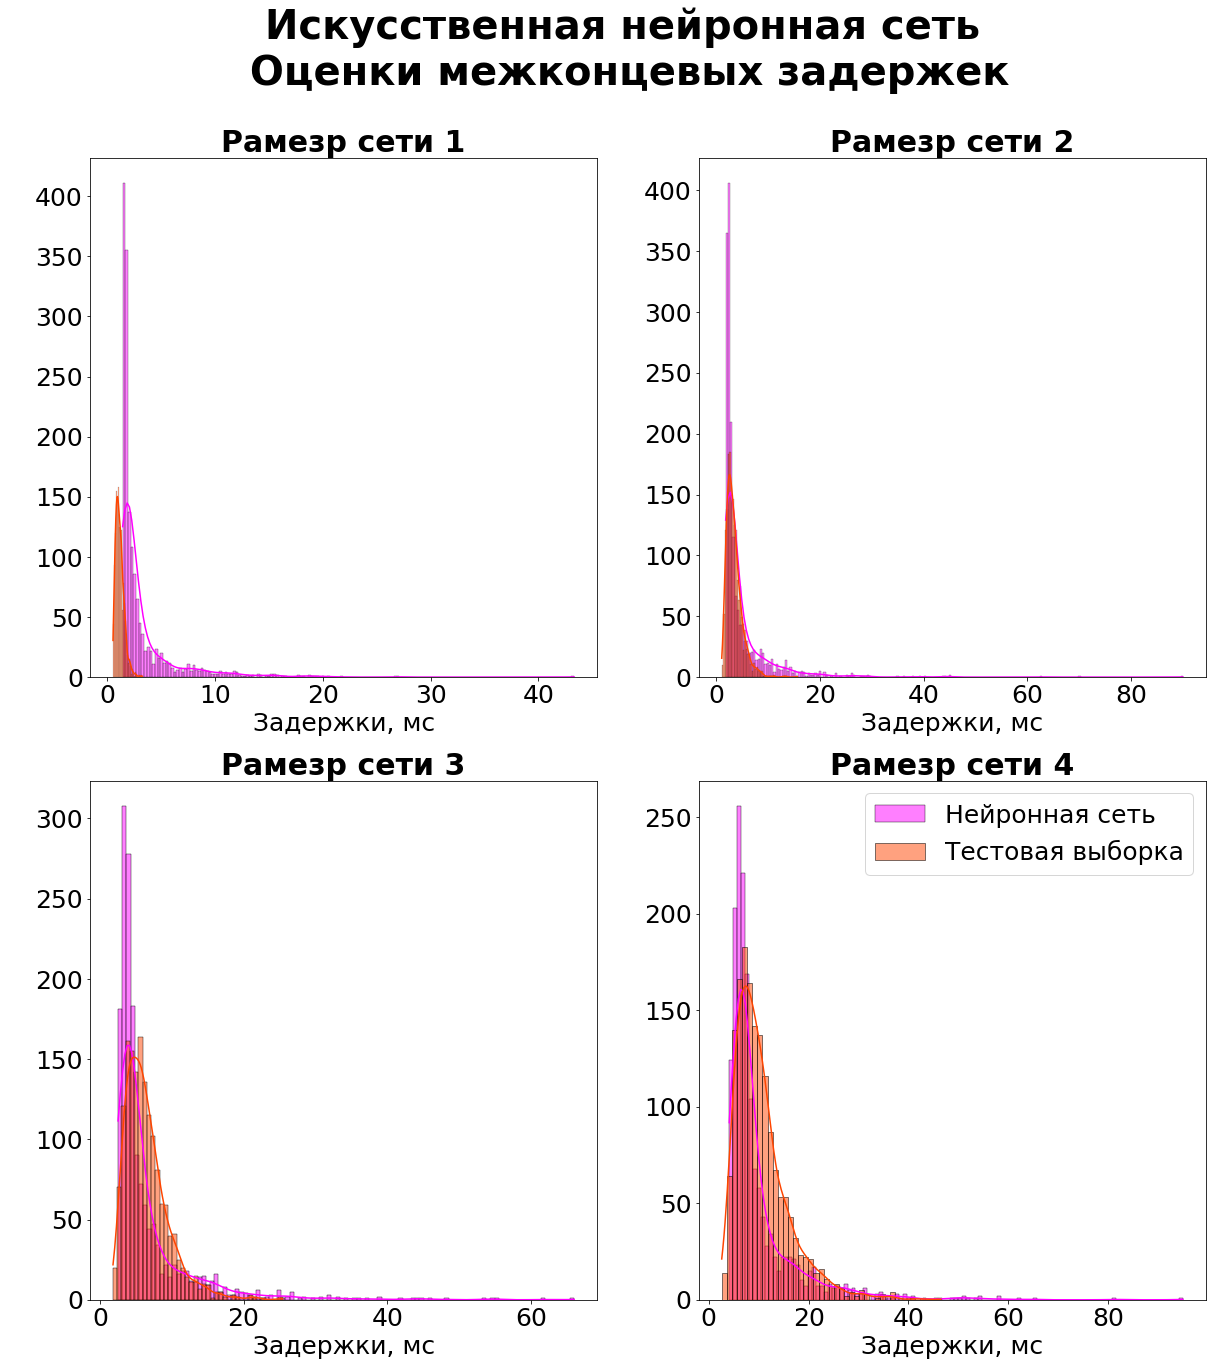

In [104]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 21))
fig.suptitle('Искусственная нейронная сеть \n Оценки межконцевых задержек \n', 
             fontsize=40,
             fontweight='bold')
# plt.subplots_adjust(top=0.92)
k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    size = [1, 2, 3, 4]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Рамезр сети ' + str(int(i)), fontweight='bold')
        ax = sns.histplot(draw_hist.loc[:,'AnnDelayEst'], 
                          color="fuchsia", 
                          label="Нейронная сеть", kde=True)
        ax = sns.histplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", 
                          label="Тестовая выборка", kde=True)
        
        
        k += 1
        plt.xlabel('Задержки, мс')
        plt.ylabel(' ')
plt.legend()
plt.savefig('data/m_ph_images/ann_histogram.png')

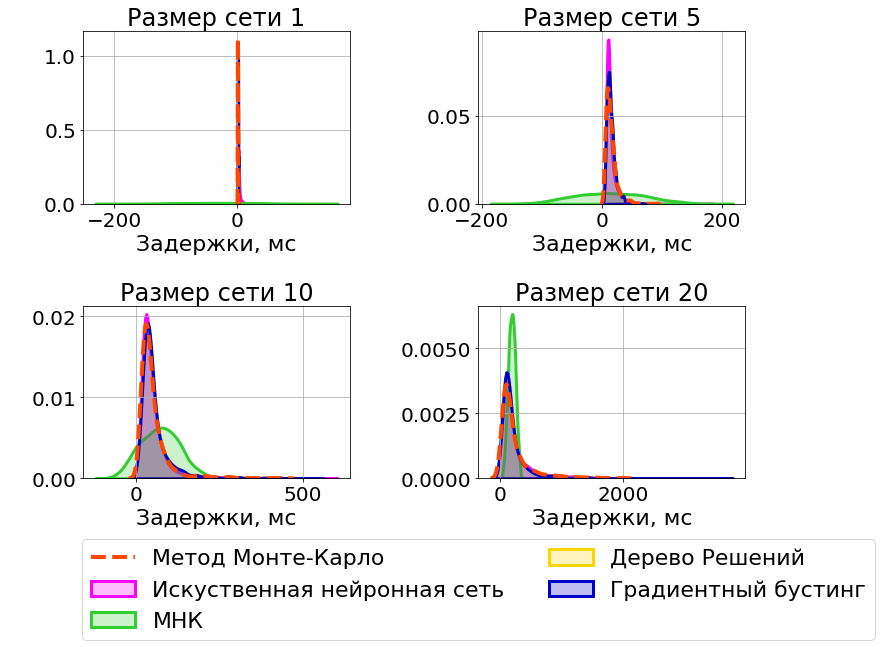

In [105]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(11, 8))

k = 1
for i in net_size:
    size = [1, 5, 10, 20]
    # size = [i for i in range(21)]
   
    if i in size:
        draw_hist = draw_data.loc[draw_data['NetSize']==i]
        ax = fig.add_subplot(2, 2, k)
        plt.title('Размер сети ' + str(int(i)), fontsize='24')
        ax = sns.kdeplot(draw_hist.loc[:,'AnnDelayEst'], 
                          color="fuchsia", shade=True, linewidth=3,
                          label="Искуственная нейронная сеть")
        ax = sns.kdeplot(draw_hist.loc[:,'LsDelayEst'], 
                         color="limegreen", shade=True, linewidth=3,
                         label="МНК")
        ax = sns.kdeplot(draw_hist.loc[:,'TreeDelayEst'], 
                          color="gold", shade=True, linewidth=3,
                          label="Дерево Решений")
        ax = sns.kdeplot(draw_hist.loc[:,'GTBDelayEst'], 
                          color="mediumblue", shade=True, linewidth=3,
                          label="Градиентный бустинг")
        ax = sns.kdeplot(draw_hist.loc[:,'DelayAvgTest'], 
                          color="orangered", linewidth=4, linestyle='--',
                          label="Метод Монте-Карло")
        plt.grid()
        k += 1
#     plt.xlabel('delay',fontsize='22')
#     plt.ylabel('Density', fontsize='22')
    plt.xlabel('Задержки, мс',fontsize='22')
    plt.ylabel(' ', fontsize='22')
    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')    
    fig.tight_layout()

ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -1), prop={'size': 22})
plt.savefig('data/m_ph_images/delay_estimate_densities.png', bbox_inches = 'tight')

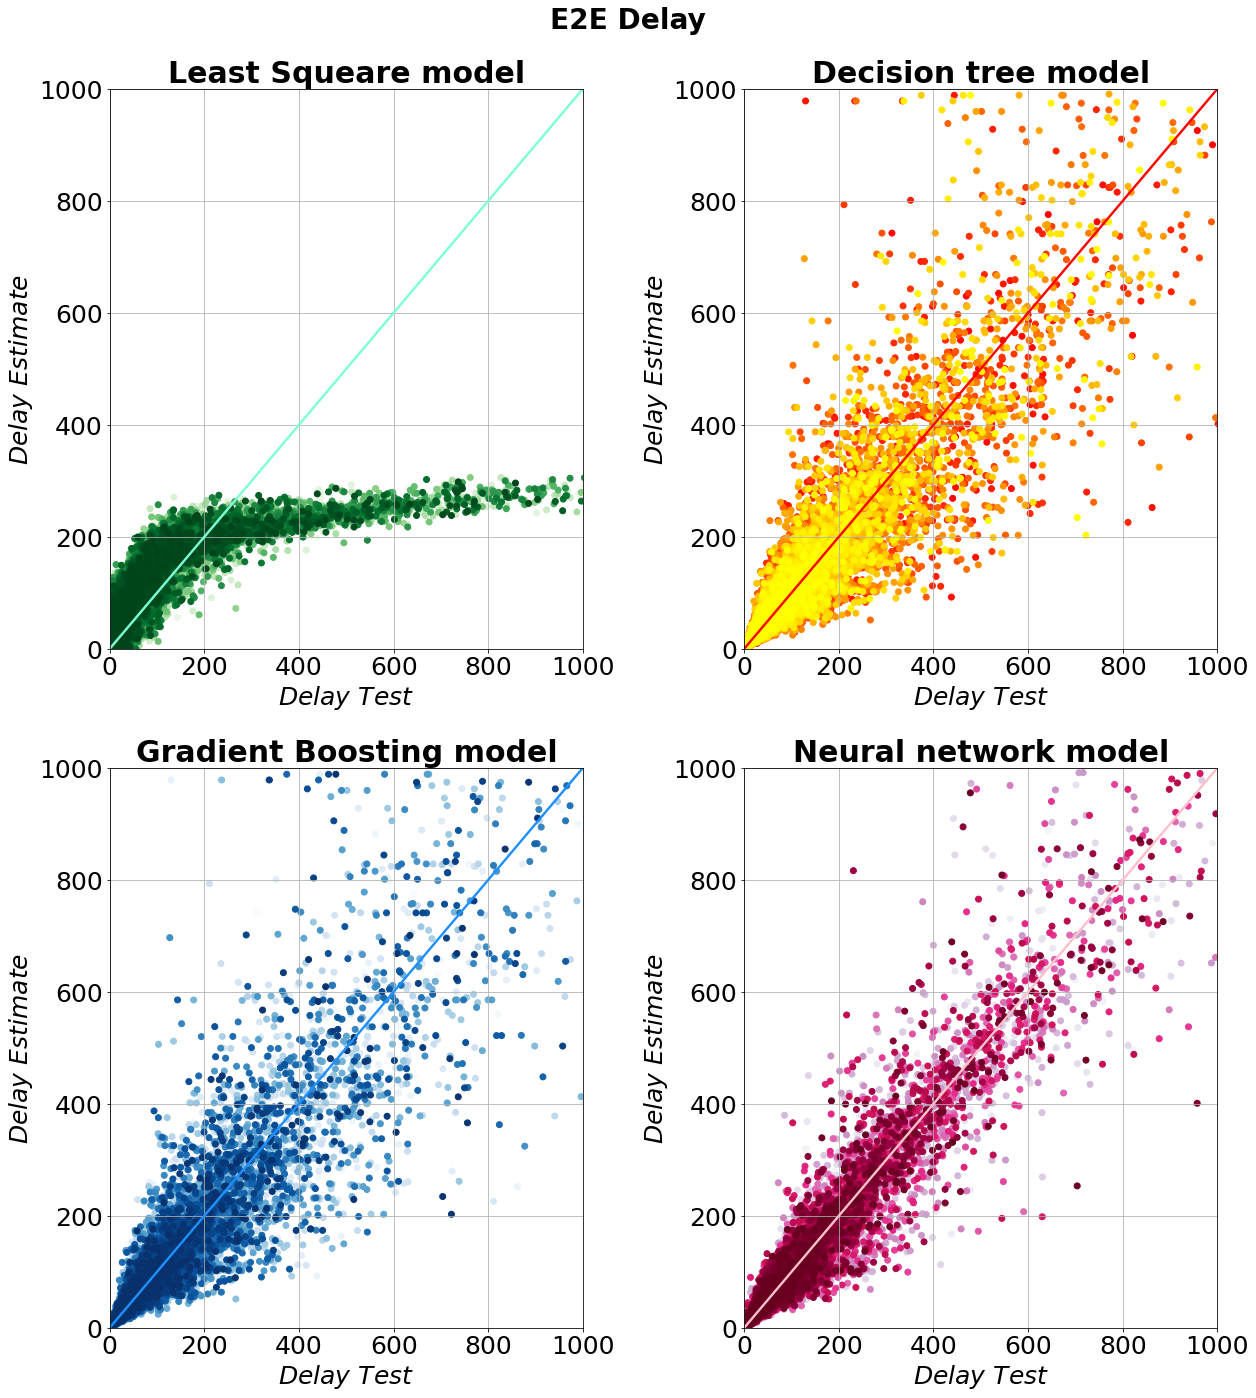

In [106]:
model = [ls_delay_estimate, 
         tree_delay_estimate,
         gtb_delay_estimate,
         ann_delay_estimate]

label = ['Least Squeare model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
column = ['LsDelayEst',
          'TreeDelayEst',
          'GTBDelayEst',
          'AnnDelayEst']
scatter_color = ['Greens',
                 'autumn',
                 'Blues',
                 'PuRd']
diag_line_color = ['aquamarine',         
                   'red',
                   'dodgerblue',
                   'pink']
simulation_data
fig = plt.figure(figsize=(18, 20))
plt.subplots_adjust(top=0.92)
fig.suptitle('E2E Delay', fontsize=28, fontweight='bold')
x = np.linspace(0,2000,100)
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(label[i], fontdict={'fontweight': 'bold'})
    cm = plt.get_cmap(scatter_color[i])
    col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
    ax = plt.scatter(draw_data['DelayAvgTest'],
                     draw_data[column[i]],  
                     c=col)
#     plt.subplots_adjust(top=0.95)
    plt.plot(x, x, 
             linestyle='-', 
             linewidth=2.4, 
             color=diag_line_color[i])
    plt.xlim([0, 1000])
    plt.ylim([0, 1000])
    plt.xlabel(r'$Delay \ Test$')
    plt.ylabel(r'$Delay \ Estimate$')
    plt.grid()
fig.tight_layout()
plt.savefig('data/m_ph_images/total_scatter_diagram.png')

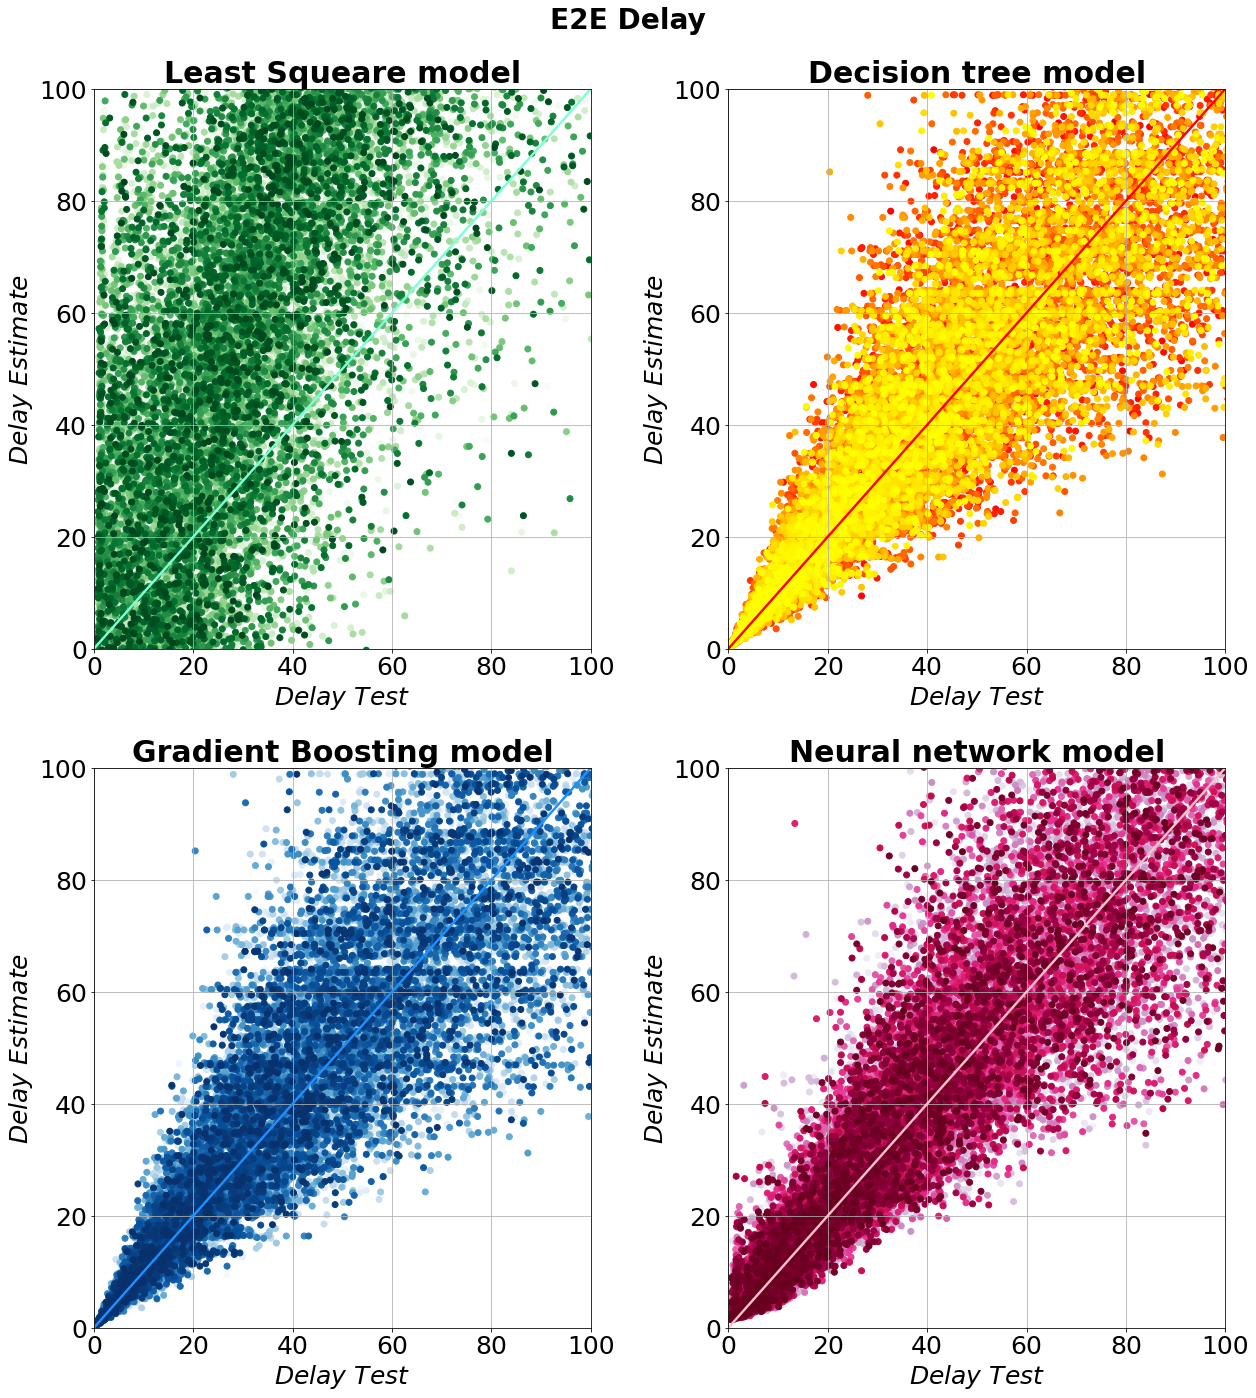

In [107]:
model = [ls_delay_estimate, 
         tree_delay_estimate,
         gtb_delay_estimate,
         ann_delay_estimate]

label = ['Least Squeare model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
column = ['LsDelayEst',
          'TreeDelayEst',
          'GTBDelayEst',
          'AnnDelayEst']
scatter_color = ['Greens',
                 'autumn',
                 'Blues',
                 'PuRd']
diag_line_color = ['aquamarine',         
                   'red',
                   'dodgerblue',
                   'pink']
simulation_data
fig = plt.figure(figsize=(18, 20))
plt.subplots_adjust(top=0.92)
fig.suptitle('E2E Delay', fontsize=28, fontweight='bold')
x = np.linspace(0,2000,100)
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(label[i], fontdict={'fontweight': 'bold'})
    cm = plt.get_cmap(scatter_color[i])
    col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
    ax = plt.scatter(draw_data['DelayAvgTest'],
                     draw_data[column[i]],  
                     c=col)
#     plt.subplots_adjust(top=0.95)
    plt.plot(x, x, 
             linestyle='-', 
             linewidth=2.4, 
             color=diag_line_color[i])
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.xlabel(r'$Delay \ Test$')
    plt.ylabel(r'$Delay \ Estimate$')
    plt.grid()
fig.tight_layout()
plt.savefig('data/m_ph_images/total_scatter_diagram.png')

In [108]:
draw_data['AnnDelayEst']

Id
75721    124.466980
80184     31.451004
19864     22.298946
76699    297.083099
92991      1.838737
            ...    
97545     61.774071
15490     44.490196
62384     14.050708
54594      1.849151
64709      7.867549
Name: AnnDelayEst, Length: 33000, dtype: float32

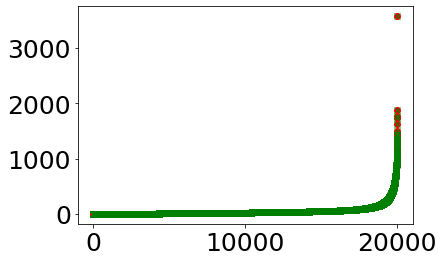

In [67]:
plt.figure()
plt.plot(np.sort(simulation_data['DelayAvg']), 'ro')
plt.plot(np.sort(simulation_data['DelayAvg']), 'gx')


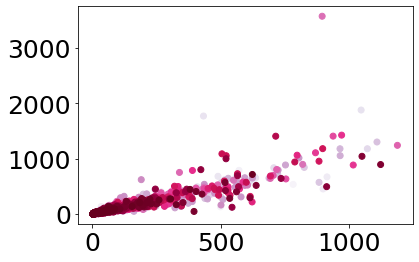

In [68]:

ax = plt.scatter(draw_data[column[3]], 
             draw_data['DelayAvgTest'], 
             c=col)

## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВЕРОЯТНОСТИ ДОСТАВКИ ПАКЕТОВ В МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

В отличии от прогнозной модели времени межконцевой задержки, для которой мы строили регрессионную модель, для модели вероятности доставки нам не критично предсказывать конкретные значения. Гораздо важнее оценивать вероятность относительно граничного значения. Мы задаемся граничным условием `BOUNDARY` для условия успешной доставки. 

Будем классификать на две группы:
- успешная доставка P $\in$ \[BOUNDARY, 1];
- вероятность потери пакетов P $\in$  [0, BOUNDARY).

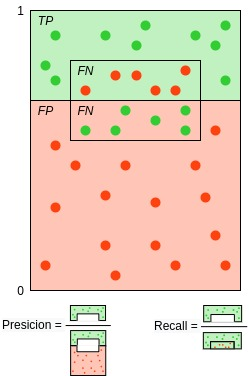

In [35]:
from IPython import display 
display.Image("../experiments/data/images/clf_metrics.jpg")

### Метрики для задач классификации:

_TP_ is true posistive;

_TN_ is true negative;

_FP_ is false positive;

_FN_ is false negative.

Для оценки моделей будем использовать следущие метрики:    
   
$$
    1. \ Precision = \dfrac{TP}{TP + FP};
$$

$$
    2. \ Recall = \dfrac{TP}{TP + FN};
$$

$$
    3. \ F_1 = 2 * \dfrac{Precision * Recall}{Precision + Recall}. 
$$

- ## Модель задачи классификации на Дереве решений

In [36]:
"""Prepare classification model using Decision Tree algorithm"""
def get_tree_classif_model(x_train, x_test, 
                           y_train, y_test, 
                           boundary=0.9, 
                           max_depth=10, 
                           splitter='best') -> Tuple[np.array, 
                                                     DecisionTreeClassifier, 
                                                     list, 
                                                     list]:
    binary_train = [1 if i >= boundary else 0 for i in y_train]
    binary_test = [1 if i >= boundary else 0 for i in y_test]
    clf = DecisionTreeClassifier(max_depth=max_depth, splitter=splitter)
    clf = clf.fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)
    return prob_estimate, clf, binary_train, binary_test

In [37]:
BOUNDARY = 0.99 
prob_clf_train = [1 if i > BOUNDARY else 0 for i in y_train['DeliveryProb']]
prob_clf_test = [1 if i > BOUNDARY else 0 for i in y_test['DeliveryProb']]

tree_prob_estimate, tree_clf, prob_clf_train, prob_clf_test = get_tree_classif_model(x_train, 
                                                                                     x_test, 
                                                                                     y_train['DeliveryProb'], 
                                                                                     y_test['DeliveryProb'],
                                                                                     boundary=BOUNDARY)

tree_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, tree_prob_estimate))
tree_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, tree_prob_estimate))
tree_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, tree_prob_estimate))
print(tree_prob_precision_score)
print(tree_prob_recall_score)
print(tree_prob_f1_score)

0.955
0.945
0.950


In [38]:
draw_data['TreeDeliveryProbTest'] = y_test['DeliveryProb']
draw_data['TreeDeliveryProbEst'] = tree_prob_estimate

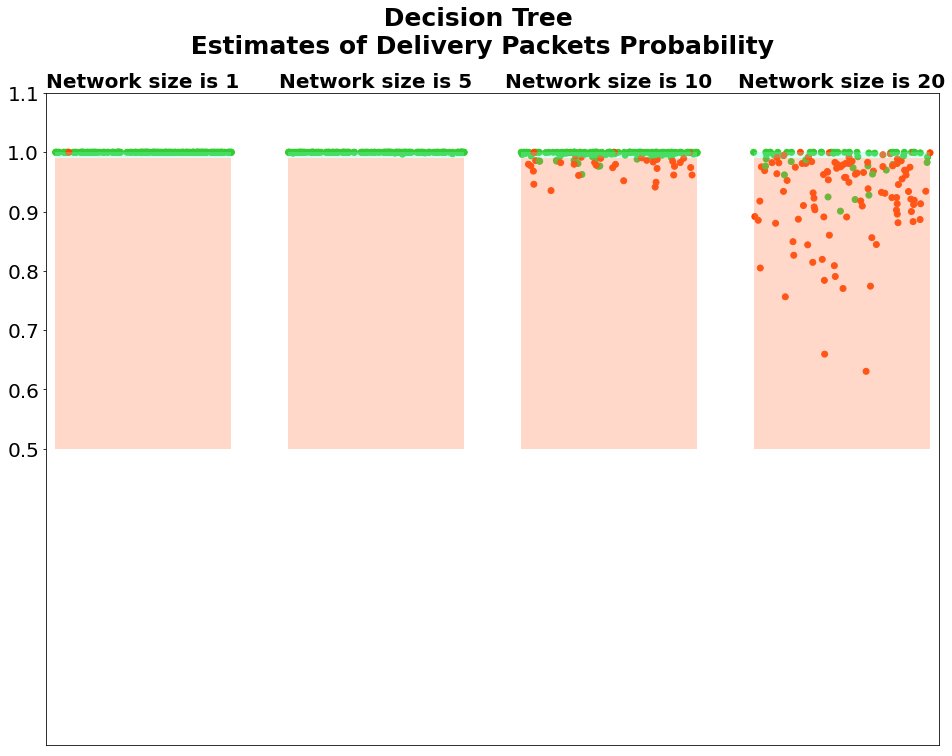

In [147]:
# YLIM = [0, 1]
# net_size = draw_data['NetSize'].unique()
# net_size.sort()
# fig = plt.figure(figsize=(16, 12))
# # fig.suptitle(r'Estimates of Delivery Packets Probability' + 
# #              ' \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
# #                 tree_prob_precision_score, 
# #                 tree_prob_recall_score, 
# #                 tree_prob_f1_score), fontsize=18)
# fig.suptitle(r' Decision Tree' + 
#              ' \n Estimates of Delivery Packets Probability', 
#              fontsize=25,
#              fontweight='bold')
# # plt.subplots_adjust(top=0.92)
# plt.yticks(np.arange(0.5, 1.1, 0.1), fontsize=20)
# plt.xticks([]) 
# k = 1
# for i in net_size:
#     size = [1, 5, 10, 20]
#     if i in size:
#         draw_plot = draw_data.loc[draw_data['NetSize']==i]
#         ax = fig.add_subplot(1, 4,  int(k))

#         plt.title('Network size is ' + str(int(i)), fontsize=20, fontweight='bold')    
#         plt.ylim(YLIM)

#         prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['TreeDeliveryProbEst']]
#         ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
#                    color=prob_color)
#         ax.add_patch(
#          patches.Rectangle(
#             (0, 0.5),
#             width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#             height=BOUNDARY-0.5,
#             facecolor = 'coral',
#             fill=True,
#             alpha=0.3))
#         ax.add_patch(
#          patches.Rectangle(
#             (0, BOUNDARY),
#             width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
#             height=1 - BOUNDARY,
#             facecolor = 'aquamarine',
#             fill=True, alpha=0.3))

#         plt.xticks(color='w')   
#         ax.set_xlabel(r'$Test \ Samples$')
#         ax.set_ylabel(r'$Probability$')
#         k += 1
#         plt.xticks(color='w')
#         plt.yticks(np.arange(0.5, 1.1, 0.1)) 
#         ax.axis('off') 

# plt.savefig('data/m_ph_images/tree_clf_prob.pdf')

- ## Модель задачи классификации на градиентном бустинге с алгоритмом CatBoost

In [148]:
"""Prepare classification model using Cat Boost algorithm"""
def get_catboost_classif_model(x_train, x_test, 
                               y_train, y_test)-> Tuple[np.array, 
                                                        CatBoostClassifier, 
                                                        list, 
                                                        list]: 
    catboost_clf = CatBoostClassifier(iterations=1000,
                                        learning_rate=0.1);
    binary_train = [1 if i > BOUNDARY else 0 for i in y_train]
    binary_test = [1 if i > BOUNDARY else 0 for i in y_test]
    catboost_clf.fit(x_train, binary_train);
    catboost_prob_estimate = catboost_clf.predict(x_test);
    
    return catboost_prob_estimate, catboost_clf, binary_train, binary_test

In [149]:
catboost_prob_estimate, catboost_clf, prob_clf_train, prob_clf_test = get_catboost_classif_model(
    x_train, 
    x_test, 
    y_train['DeliveryProb'], 
    y_test['DeliveryProb'])

catboost_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, catboost_prob_estimate))
catboost_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, catboost_prob_estimate))
print(catboost_prob_precision_score)
print(catboost_prob_recall_score)
print(catboost_prob_f1_score)

0:	learn: 0.5713575	total: 77.9ms	remaining: 1m 17s
1:	learn: 0.4911192	total: 86.2ms	remaining: 43s
2:	learn: 0.4305515	total: 93.9ms	remaining: 31.2s
3:	learn: 0.3817384	total: 99.7ms	remaining: 24.8s
4:	learn: 0.3537661	total: 104ms	remaining: 20.7s
5:	learn: 0.3262584	total: 108ms	remaining: 17.8s
6:	learn: 0.3056929	total: 111ms	remaining: 15.7s
7:	learn: 0.2866082	total: 114ms	remaining: 14.1s
8:	learn: 0.2708861	total: 116ms	remaining: 12.8s
9:	learn: 0.2579511	total: 119ms	remaining: 11.7s
10:	learn: 0.2514405	total: 121ms	remaining: 10.9s
11:	learn: 0.2443166	total: 123ms	remaining: 10.1s
12:	learn: 0.2368399	total: 125ms	remaining: 9.49s
13:	learn: 0.2315963	total: 127ms	remaining: 8.96s
14:	learn: 0.2277944	total: 129ms	remaining: 8.49s
15:	learn: 0.2226465	total: 132ms	remaining: 8.09s
16:	learn: 0.2198268	total: 134ms	remaining: 7.74s
17:	learn: 0.2172729	total: 136ms	remaining: 7.41s
18:	learn: 0.2142764	total: 138ms	remaining: 7.1s
19:	learn: 0.2111626	total: 139ms	remai

195:	learn: 0.1273845	total: 469ms	remaining: 1.92s
196:	learn: 0.1269963	total: 471ms	remaining: 1.92s
197:	learn: 0.1268057	total: 472ms	remaining: 1.91s
198:	learn: 0.1265457	total: 474ms	remaining: 1.91s
199:	learn: 0.1262705	total: 476ms	remaining: 1.9s
200:	learn: 0.1258432	total: 478ms	remaining: 1.9s
201:	learn: 0.1255846	total: 480ms	remaining: 1.89s
202:	learn: 0.1251257	total: 482ms	remaining: 1.89s
203:	learn: 0.1248773	total: 483ms	remaining: 1.89s
204:	learn: 0.1247295	total: 485ms	remaining: 1.88s
205:	learn: 0.1243509	total: 488ms	remaining: 1.88s
206:	learn: 0.1241542	total: 490ms	remaining: 1.88s
207:	learn: 0.1237840	total: 492ms	remaining: 1.87s
208:	learn: 0.1235560	total: 494ms	remaining: 1.87s
209:	learn: 0.1233608	total: 496ms	remaining: 1.87s
210:	learn: 0.1231826	total: 498ms	remaining: 1.86s
211:	learn: 0.1229129	total: 500ms	remaining: 1.86s
212:	learn: 0.1227042	total: 502ms	remaining: 1.85s
213:	learn: 0.1225886	total: 503ms	remaining: 1.85s
214:	learn: 0.

393:	learn: 0.0854736	total: 855ms	remaining: 1.31s
394:	learn: 0.0853556	total: 858ms	remaining: 1.31s
395:	learn: 0.0852352	total: 860ms	remaining: 1.31s
396:	learn: 0.0851450	total: 863ms	remaining: 1.31s
397:	learn: 0.0849730	total: 865ms	remaining: 1.31s
398:	learn: 0.0848232	total: 867ms	remaining: 1.31s
399:	learn: 0.0846188	total: 869ms	remaining: 1.3s
400:	learn: 0.0844501	total: 871ms	remaining: 1.3s
401:	learn: 0.0843202	total: 873ms	remaining: 1.3s
402:	learn: 0.0841477	total: 875ms	remaining: 1.3s
403:	learn: 0.0839258	total: 877ms	remaining: 1.29s
404:	learn: 0.0837895	total: 879ms	remaining: 1.29s
405:	learn: 0.0834879	total: 883ms	remaining: 1.29s
406:	learn: 0.0833627	total: 885ms	remaining: 1.29s
407:	learn: 0.0831290	total: 887ms	remaining: 1.29s
408:	learn: 0.0829294	total: 889ms	remaining: 1.28s
409:	learn: 0.0827410	total: 891ms	remaining: 1.28s
410:	learn: 0.0826427	total: 893ms	remaining: 1.28s
411:	learn: 0.0824708	total: 895ms	remaining: 1.28s
412:	learn: 0.08

572:	learn: 0.0637395	total: 1.24s	remaining: 925ms
573:	learn: 0.0635827	total: 1.24s	remaining: 923ms
574:	learn: 0.0635239	total: 1.25s	remaining: 921ms
575:	learn: 0.0633835	total: 1.25s	remaining: 919ms
576:	learn: 0.0632581	total: 1.25s	remaining: 916ms
577:	learn: 0.0631768	total: 1.25s	remaining: 914ms
578:	learn: 0.0630691	total: 1.25s	remaining: 912ms
579:	learn: 0.0629850	total: 1.26s	remaining: 910ms
580:	learn: 0.0629103	total: 1.26s	remaining: 908ms
581:	learn: 0.0627607	total: 1.26s	remaining: 906ms
582:	learn: 0.0626210	total: 1.26s	remaining: 903ms
583:	learn: 0.0625149	total: 1.27s	remaining: 907ms
584:	learn: 0.0623697	total: 1.27s	remaining: 905ms
585:	learn: 0.0622507	total: 1.28s	remaining: 903ms
586:	learn: 0.0621632	total: 1.28s	remaining: 900ms
587:	learn: 0.0620504	total: 1.28s	remaining: 898ms
588:	learn: 0.0619332	total: 1.28s	remaining: 896ms
589:	learn: 0.0617875	total: 1.28s	remaining: 893ms
590:	learn: 0.0616838	total: 1.29s	remaining: 891ms
591:	learn: 

782:	learn: 0.0466653	total: 1.63s	remaining: 453ms
783:	learn: 0.0465924	total: 1.64s	remaining: 451ms
784:	learn: 0.0465189	total: 1.64s	remaining: 448ms
785:	learn: 0.0465005	total: 1.64s	remaining: 446ms
786:	learn: 0.0464591	total: 1.64s	remaining: 444ms
787:	learn: 0.0464256	total: 1.64s	remaining: 442ms
788:	learn: 0.0463585	total: 1.64s	remaining: 440ms
789:	learn: 0.0462921	total: 1.65s	remaining: 438ms
790:	learn: 0.0462425	total: 1.65s	remaining: 435ms
791:	learn: 0.0461237	total: 1.65s	remaining: 433ms
792:	learn: 0.0460713	total: 1.65s	remaining: 431ms
793:	learn: 0.0459255	total: 1.65s	remaining: 429ms
794:	learn: 0.0458661	total: 1.66s	remaining: 427ms
795:	learn: 0.0457638	total: 1.66s	remaining: 425ms
796:	learn: 0.0456996	total: 1.66s	remaining: 423ms
797:	learn: 0.0456620	total: 1.66s	remaining: 420ms
798:	learn: 0.0455831	total: 1.66s	remaining: 418ms
799:	learn: 0.0455121	total: 1.66s	remaining: 416ms
800:	learn: 0.0454531	total: 1.67s	remaining: 414ms
801:	learn: 

0.944
0.943
0.943


In [150]:
draw_data['CatBoostProbEst'] = catboost_prob_estimate

- ## Модель задачи классификации c помощью логистической регрессии

In [151]:
"""Prepare classification model using Logistic Regression algorithm"""
def get_logress_classif_model(x_train, x_test, 
                              y_train, y_test,
                              boundary=0.9)-> Tuple[np.array, LogisticRegression,
                                                    list, list]: 
    logres_model = LogisticRegression(max_iter=1000)
    binary_train = [1 if i > boundary else 0 for i in y_train]
    binary_test = [1 if i > boundary else 0 for i in y_test]
    logres_model.fit(x_train, binary_train)
    logres_prob_estimate = logres_model.predict(x_test)
    
    return logres_prob_estimate, logres_model, binary_train, binary_test

In [152]:
logres_prob_estimate, logres_model, prob_clf_train, prob_clf_test = get_logress_classif_model(x_train, 
                                                                                x_test, 
                                                                                y_train['DeliveryProb'], 
                                                                                y_test['DeliveryProb'],
                                                                                boundary=BOUNDARY)

logres_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, logres_prob_estimate))
logres_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, logres_prob_estimate))
logres_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, logres_prob_estimate))
print(logres_prob_precision_score)
print(logres_prob_recall_score)
print(logres_prob_f1_score)

0.890
0.923
0.907


In [153]:
draw_data['LogResProbEst'] = logres_prob_estimate

In [ ]:
COLUMNS = (
    'ArrM1',
    'ArrAvg',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)

arr_m1 = [np.random.uniform(0, 10)]
arr_cv = [np.random.uniform(0.5, 3)]

rho =  np.arange(0.1, 1, 0.05)

srv_cv = [np.random.uniform(0.5, 3)]

net_size = np.arange(1, 20+1)
capacity = [500]
